In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely import geometry
from collections import Counter
import os
import json
import pandas as pd
import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm
import cv2
import pickle
from rasterio.tools.mask import mask
import seaborn as sns
import random
from rasterio.merge import merge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
from sklearn.externals import joblib
from sklearn.metrics import mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score

%matplotlib inline

## load npy files into dataframes

Each stacked image has all the band information from the satellite imagery (both pan sharpened and non pan sharpened). Masks have 0s and 1s demarcating damaged buildings. The four images/masks correspond to the four areas for which we have satellite imagery (different parts of the Philippines).

In [3]:
stacked_image1 = np.load('stacked_imgs_masks/stacked_image1.npy')
stacked_image2 = np.load('stacked_imgs_masks/stacked_image2.npy')
stacked_image3 = np.load('stacked_imgs_masks/stacked_image3.npy')
stacked_image4 = np.load('stacked_imgs_masks/stacked_image4.npy')
stacked_image5 = np.load('stacked_imgs_masks/stacked_image5.npy')

mask1 = np.load('stacked_imgs_masks/mask1.npy')
mask2 = np.load('stacked_imgs_masks/mask2.npy')
mask3 = np.load('stacked_imgs_masks/mask3.npy')
mask4 = np.load('stacked_imgs_masks/mask4.npy')
mask5 = np.load('stacked_imgs_masks/mask5.npy')

In [4]:
def to_df(stacked_image, mask):
    
    df = pd.DataFrame(stacked_image[:, :, 1].flatten())

    for i in range(1, stacked_image.shape[2]):
        df1 = pd.DataFrame(stacked_image[:, :, i].flatten())
        df = pd.concat([df, df1], axis = 1)
    
    df['ground_truth'] = mask.flatten()
    
    df.columns = ['b1_pre', 'b2_pre', 'b3_pre', 'b4_pre', 'b5_pre', 'b6_pre', 'b7_pre',
       'b8_pre', 'b9_pre', 'b10_pre', 'b11_pre', 'r_pre', 'g_pre', 'b_pre', 'b1_post', 
        'b2_post', 'b3_post', 'b4_post', 'b5_post', 'b6_post', 'b7_post', 'b8_post',
       'b9_post', 'b10_post', 'b11_post', 'r_post', 'g_post', 'b_post',
        'b1_sub', 'b2_sub', 'b3_sub', 'b4_sub', 'b5_sub', 'b6_sub', 'b7_sub', 'b8_sub', 
        'b9_sub', 'b10_sub', 'b11_sub', 'r_sub', 'g_sub', 'b_sub', 'ground_truth']
    
    return df
    

In [5]:
df1 = to_df(stacked_image1, mask1)
df2 = to_df(stacked_image2, mask2)
df3 = to_df(stacked_image3, mask3)
df4 = to_df(stacked_image4, mask4)

## random forest (balanced samples)

**Train on top half, predict on bottom**

Take bottom 50% of three images (1, 2, 4) as test set. Train on balanced sample from the top half of the same three images.

In [6]:
# creating df from three images
full_df = pd.concat([df1, df2, df4]).reset_index().drop('index', axis = 1)

In [7]:
df1.shape

(153600, 43)

In [8]:
df2.shape

(491520, 43)

In [9]:
df3.shape

(135168, 43)

In [10]:
# take bottom 50 percent of each image for test set

In [11]:
a = round(df1.shape[0]*.5)
b = df1.shape[0]
c = df1.shape[0] + round(df2.shape[0]*.5)
d = df1.shape[0] + df2.shape[0]
e = df1.shape[0] + df2.shape[0] + round(df3.shape[0]*.5)
f = df1.shape[0] + df2.shape[0] + df3.shape[0]

In [12]:
print(a, b, c, d, e, f)

76800 153600 399360 645120 712704 780288


In [13]:
test_df = pd.concat([full_df.iloc[a:b, :], full_df.iloc[c:d, :], full_df.iloc[e:f, :]])

In [14]:
# remainder is top half of three images
remainder = pd.concat([full_df.iloc[:a, :], full_df.iloc[b:c, :], full_df.iloc[d:e, :]])

In [15]:
test_df.ground_truth.value_counts()

0    317204
1     23788
Name: ground_truth, dtype: int64

In [22]:
remainder.ground_truth.value_counts()

0    369631
1     20513
Name: ground_truth, dtype: int64

In [23]:
# create balanced sample from top halves (remainder)
# zero_indices are rows where ground truth is 0 (no damage)
zero_indices = remainder[remainder.ground_truth == 0].index
# select equal number of rows where ground truth == 1 and ground truth == 0
random_indices = np.random.choice(zero_indices, remainder.ground_truth.value_counts()[1], replace=False)

zero_sample = remainder.loc[random_indices]
nonzero_sample = remainder[remainder.ground_truth == 1]

In [25]:
balanced_df = pd.concat([zero_sample, nonzero_sample], axis = 0)

In [26]:
balanced_df.head()

,b1_pre,b2_pre,b3_pre,b4_pre,b5_pre,b6_pre,b7_pre,b8_pre,b9_pre,b10_pre,...,b6_sub,b7_sub,b8_sub,b9_sub,b10_sub,b11_sub,r_sub,g_sub,b_sub,ground_truth
17799,0.092719,0.092719,0.125805,0.269536,0.220621,0.145741,0.081321,0.073816,0.042037,0.022545,...,0.449299,0.456859,0.480292,0.571733,0.663749,0.501404,0.207566,0.768457,0.749378,0
240287,0.374854,0.374854,0.420147,0.576169,0.569915,0.538371,0.360474,0.109501,0.091218,0.107413,...,0.291789,0.390699,0.599886,0.482930,0.450465,0.333402,0.247002,0.519198,0.593609,0
221864,0.169249,0.169249,0.282888,0.580683,0.541624,0.343099,0.228587,0.084019,0.096479,0.130021,...,0.309954,0.393645,0.592509,0.488948,0.473180,0.333123,0.250540,0.525543,0.616247,0
230567,0.251853,0.251853,0.292980,0.477061,0.432320,0.393482,0.218688,0.676682,0.380413,0.248617,...,0.297842,0.372623,0.608358,0.508906,0.479622,0.326033,0.308186,0.468965,0.549818,0
311645,0.136540,0.136540,0.233701,0.530442,0.477484,0.295372,0.195344,0.067734,0.061146,0.083602,...,0.299813,0.368815,0.577420,0.478306,0.458603,0.325999,0.256245,0.551006,0.633538,0


In [27]:
balanced_df.shape

(41026, 43)

In [28]:
test_df.shape

(340992, 43)

In [29]:
X_train = balanced_df.iloc[:, :-1]
y_train = balanced_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

             precision    recall  f1-score   support

          0       0.97      0.92      0.95    317204
          1       0.37      0.62      0.47     23788

avg / total       0.93      0.90      0.91    340992

Model: Random Forest Classifier
AUC: 0.91219776062



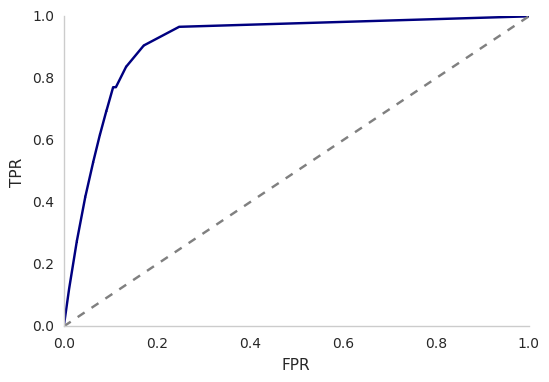

In [33]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: Random Forest Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('Random Forest ROC');
sns.despine()

In [72]:
# create helper function that allows us to set the threshold for the classification
def threshold_wrapper(proba_list, threshold):
    output_list = []
    for proba in proba_list:
        if proba >= threshold:
            output_list.append(1)
        else:
            output_list.append(0)
    return output_list

In [73]:
y_pred = threshold_wrapper(y_proba, .9)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96    360687
          1       0.46      0.32      0.38     29457

avg / total       0.91      0.92      0.91    390144

0.121776718873


In [74]:
y_pred = threshold_wrapper(y_proba, .92)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.99      0.96    360687
          1       0.50      0.15      0.23     29457

avg / total       0.90      0.92      0.90    390144

0.0555810387498


In [48]:
# save model
joblib.dump(rf, 'best_rf.pkl') 

['best_rf.pkl']

In [49]:
# explore feature importances
sorted_features = sorted(zip(X_train.columns,rf.feature_importances_), key = lambda x: x[1], reverse = True)
for feature in sorted_features:
       print(feature)

('b11_sub', 0.1122234030259186)
('b6_sub', 0.1118456385037619)
('b1_sub', 0.078080161549225341)
('b3_sub', 0.057561763976787562)
('b5_sub', 0.053343263794707121)
('b4_pre', 0.052308733735946578)
('b3_post', 0.046776702649337407)
('b8_post', 0.038891855962687231)
('b11_pre', 0.0351885904797564)
('b1_post', 0.034137464148296451)
('b8_pre', 0.03330059856860422)
('g_pre', 0.025562307440889009)
('b10_sub', 0.02276053601699642)
('b10_post', 0.020159073099823184)
('b10_pre', 0.019509793410883491)
('b8_sub', 0.019198840308527882)
('b_post', 0.014648795194358025)
('g_post', 0.01339358779954029)
('r_post', 0.012917566340539352)
('b2_post', 0.012519067272294907)
('b4_post', 0.012292007481920244)
('b11_post', 0.011975224660306429)
('b9_pre', 0.011971970906296731)
('b4_sub', 0.010868247629840223)
('b9_sub', 0.010774885329328302)
('b5_post', 0.0106904197858814)
('b6_pre', 0.010216479639409002)
('b9_post', 0.0097533404483684857)
('b_pre', 0.0087065861240561999)
('g_sub', 0.0086511215333867006)
('b7_p

**Train on three images, predict on new image**

Create balanced dataframe for training from images 1, 2, 4. Test on image 3.

In [57]:
remainder = pd.concat([df1, df2, df4], axis = 0).reset_index().drop('index', axis = 1)

In [58]:
remainder.ground_truth.value_counts()

0    686835
1     44301
Name: ground_truth, dtype: int64

In [59]:
zero_indices = remainder[remainder.ground_truth == 0].index
random_indices = np.random.choice(zero_indices, remainder.ground_truth.value_counts()[1], replace=False)
zero_sample = remainder.loc[random_indices]

In [60]:
nonzero_sample = remainder[remainder.ground_truth == 1]

In [61]:
balanced_df = pd.concat([zero_sample, nonzero_sample], axis = 0)

In [62]:
X_train = balanced_df.iloc[:, :-1]
y_train = balanced_df.iloc[:, -1]
X_test = df3.iloc[:, :-1]
y_test = df3.iloc[:, -1]

             precision    recall  f1-score   support

          0       0.94      0.54      0.69    122416
          1       0.14      0.69      0.23     12752

avg / total       0.87      0.55      0.64    135168

Model: Random Forest Classifier
AUC: 0.676731951842



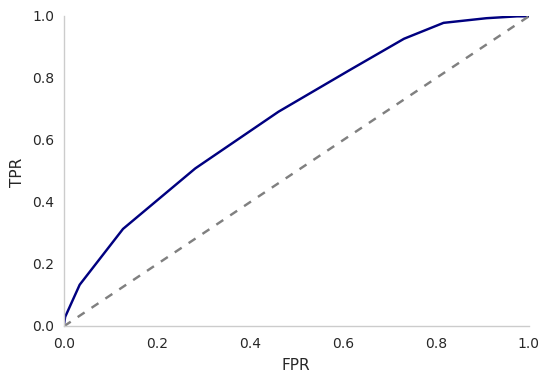

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: Random Forest Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('Random Forest ROC');
sns.despine()

In [197]:
y_pred = threshold_wrapper(y_proba, .2)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.16      0.27    122416
          1       0.11      0.96      0.19     12752

avg / total       0.89      0.23      0.26    135168

0.015780487503


In [198]:
y_pred = threshold_wrapper(y_proba, .4)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.36      0.52    122416
          1       0.11      0.78      0.20     12752

avg / total       0.86      0.40      0.49    135168

0.00609450181109


In [199]:
y_pred = threshold_wrapper(y_proba, .6)
print(classification_report(y_test, y_pred))
print(adjusted_mutual_info_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.71      0.81    122416
          1       0.15      0.50      0.24     12752

avg / total       0.86      0.69      0.75    135168

0.0137401494419


## density map

In [200]:
stacked_image3.shape

(352, 384, 42)

In [201]:
pixel_matrix = np.reshape(y_pred, (352, 384))
# isolating non zero pixel coordinates for plotting
x = np.nonzero(pixel_matrix)[1]
y = np.nonzero(pixel_matrix)[0]
pix_coords = np.vstack((x, y)).T
pix_coords.shape

(41545, 2)

In [202]:
pix_coords

array([[  1,   0],
       [  2,   0],
       [  3,   0],
       ..., 
       [365, 351],
       [376, 351],
       [377, 351]])

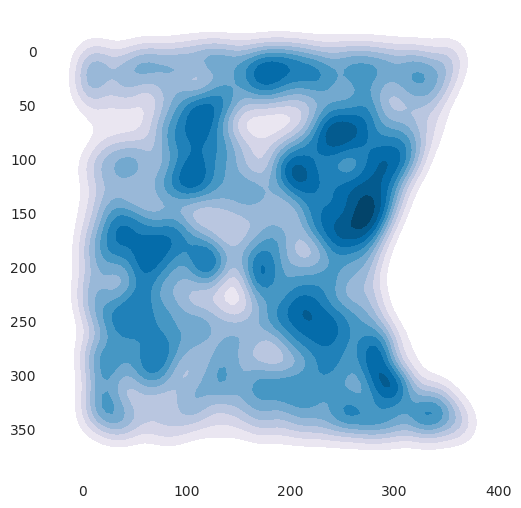

In [203]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.kdeplot(pix_coords, shade = True, cmap = "PuBu")
ax.invert_yaxis()
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
plt.show()

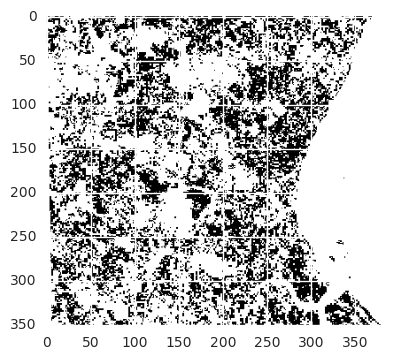

In [204]:
plt.imshow(pixel_matrix)